# Imports

## Librairies

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.formula.api import ols

## Options

In [2]:
!python --version
print('\n'.join(f'{m.__name__} {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

sns.set()

pd.options.display.float_format = "{:.2f}".format
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Python 3.11.5
pandas 2.1.4
numpy 1.26.2
seaborn 0.12.2
statsmodels.api 0.14.0


## Data

In [3]:
df = pd.read_csv("../data/df_final.csv", sep=";")
df.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,year,month,day,range_age
0,0_1518,2022-05-20 13:21:29,s_211425,c_103,4.18,0,f,39,2022,5,20,38-42
1,0_1627,2022-06-18 05:55:31,s_225494,c_103,3.99,0,f,39,2022,6,18,38-42
2,0_1104,2023-02-08 17:31:06,s_338755,c_103,13.21,0,f,39,2023,2,8,38-42
3,0_1390,2021-04-20 06:18:39,s_23078,c_103,19.37,0,f,39,2021,4,20,38-42
4,0_1547,2022-03-15 19:54:53,s_179629,c_103,8.99,0,f,39,2022,3,15,38-42


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679332 non-null  float64
 5   categ       679332 non-null  int64  
 6   sex         679332 non-null  object 
 7   age         679332 non-null  int64  
 8   year        679332 non-null  int64  
 9   month       679332 non-null  int64  
 10  day         679332 non-null  int64  
 11  range_age   679332 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 62.2+ MB


# CA

Commençons par regarder les différents chiffres d'affaires annuels. Gardons en tête ce que l'EDA nous a appris :

- Il y avait un trou concernant la catégorie 1 dans le mois d'octobre 2021
- L'année 2022 et la plus parlante car il y a toute une année complète
- L'année 2023 n'est pas encore terminée

In [5]:
total_revenue = df["price"].sum()

# CA sur les trois années recensées
print("Le chiffre d'affaires sur l'année 2021 2022 et 2023 (année en cours) est de {:,.2f} € "
      .format(total_revenue))

Le chiffre d'affaires sur l'année 2021 2022 et 2023 (année en cours) est de 11,856,080.12 € 


In [6]:
annual_revenue = df.groupby(["year"])["price"].sum()
annual_revenue_formatted = annual_revenue.apply(lambda x: f"{x:,.2f}".replace(",", " "))

# CA sur chaque année
print(annual_revenue_formatted)

year
2021    4 771 752.24
2022    6 109 958.61
2023      974 369.27
Name: price, dtype: object


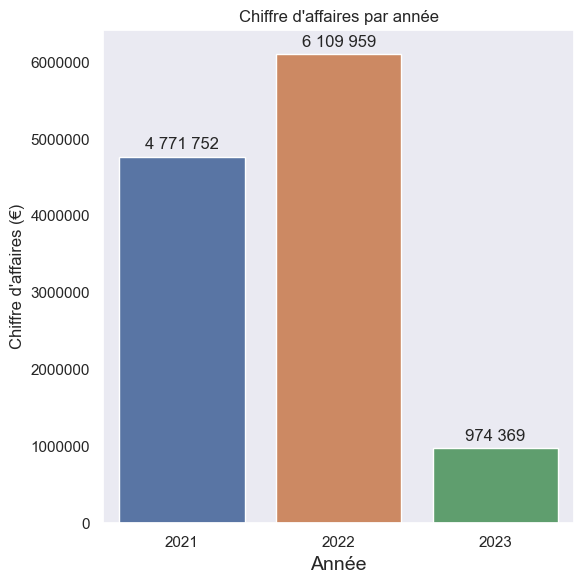

In [7]:
# Préparation des données
df_ca = annual_revenue.reset_index()
df_ca["year"] = df_ca["year"].astype(str)

# Affichage
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=df_ca, x="year", y="price")

# Valeurs formatées sur les barres
for container in ax.containers:
    labels = [f"{v:,.0f}".replace(",", " ") for v in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3)

# Style
ax.set_title("Chiffre d'affaires par année")
ax.set_xlabel("Année", fontsize=14)
ax.set_ylabel("Chiffre d'affaires (€)")
ax.ticklabel_format(axis="y", style='plain')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Customers 

In [8]:
customers = df.groupby("client_id")[["price"]].sum()

sorted_customers = customers.sort_values("price", ascending=False)
sorted_customers.head(10)

,price
client_id,
c_1609,324033.35
c_4958,289760.34
c_6714,153662.76
c_3454,113669.85
c_3263,5276.87
c_1570,5271.62
c_2899,5214.05
c_2140,5208.82
c_7319,5155.77


Première observation : 4 clients se démarquent du reste. Ces valeurs paraissent beaucoup trop grande pour que ça soit des particuliers.  
Deuxième observation : Au vu des montants cumulés, il est fort proable que ça soit des entreprises/associations/communes.

On va donc diviser notre analyse : B2B et B2C

## B2C

In [9]:
# Création d'une copie du df pour ensuite enlever facilement les clients B2B
df_b2c = df.copy()

In [10]:
# Supressions des clients B2B dans le dataframe B2C
df_b2c.drop(df_b2c[(df_b2c["client_id"] == "c_1609")].index, inplace=True)
df_b2c.drop(df_b2c[(df_b2c["client_id"] == "c_4958")].index, inplace=True)
df_b2c.drop(df_b2c[(df_b2c["client_id"] == "c_6714")].index, inplace=True)
df_b2c.drop(df_b2c[(df_b2c["client_id"] == "c_3454")].index, inplace=True)

In [11]:
df_b2c.shape

(632689, 12)

In [12]:
df.shape

(679332, 12)

## B2B

### CA clients B2B

#### Réunis

In [13]:
# Création d'un df pour analyser ces 4 clients non-particuliers pour quelques cellules plus bas
df_b2b = df.loc[
    (df['client_id']=='c_1609') | 
    (df['client_id']=='c_4958') | 
    (df['client_id']=='c_6714') | 
    (df['client_id']=='c_3454'), :]

In [14]:
# Chiffre d'affaires généré par ces 4 clients
b2b_revenue = df_b2b['price'].sum()

print("Le chiffre d'affaires total généré par ces 4 clients est de {:,.2f} € "
      .format(b2b_revenue)
      .replace(',',' '))

Le chiffre d'affaires total généré par ces 4 clients est de 881 126.30 € 


In [15]:
# Proportion de ces 4 clients par rapport au chiffre d'affaires total
proportion_revenue_b2b = b2b_revenue / total_revenue*100

print("La proportion du chiffre d'affaires généré par ces 4 clients, par rapport au chiffre d'affaires total est de {:,.2f} % "
      .format(proportion_revenue_b2b))

La proportion du chiffre d'affaires généré par ces 4 clients, par rapport au chiffre d'affaires total est de 7.43 % 


Selon le tableau et le graphique, le CA des 4 clients B2B réunis est d'un niveau légèrement égal si on prend en compte toutes les catégories.

Regardons maintenant de façon scindé.

#### Séparés

In [16]:
# Stockage des informations de ces 4 clients dans des variables séparés
client_1609 = df_b2b.loc[df_b2b['client_id'] == 'c_1609', :]
client_4958 = df_b2b.loc[df_b2b['client_id'] == 'c_4958', :]
client_6714 = df_b2b.loc[df_b2b['client_id'] == 'c_6714', :]
client_3454 = df_b2b.loc[df_b2b['client_id'] == 'c_3454', :]

In [17]:
# On fait un pivot en prenant comme index l'année. 
# On va pouvoir également afficher le chiffre d'affaires de ces 4 clients par catégorie
df_b2b_categ = pd.pivot_table(
    df_b2b, index='year', columns='categ', values='price', 
    aggfunc={'price' : 'sum'})

# Exemple avec un des 4 clients
client_1609.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,year,month,day,range_age
22561,0_1446,2022-10-05 07:43:00,s_278030,c_1609,8.09,0,m,45,2022,10,5,43-47
22562,0_1102,2021-10-24 13:25:39,s_109442,c_1609,4.63,0,m,45,2021,10,24,43-47
22563,0_1574,2021-10-06 02:49:56,s_100652,c_1609,9.67,0,m,45,2021,10,6,43-47
22564,0_2291,2021-03-07 15:58:19,s_3088,c_1609,12.99,0,m,45,2021,3,7,43-47
22565,0_1611,2022-03-06 15:36:09,s_175223,c_1609,11.99,0,m,45,2022,3,6,43-47


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679332 non-null  float64
 5   categ       679332 non-null  int64  
 6   sex         679332 non-null  object 
 7   age         679332 non-null  int64  
 8   year        679332 non-null  int64  
 9   month       679332 non-null  int64  
 10  day         679332 non-null  int64  
 11  range_age   679332 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 62.2+ MB


In [19]:
# On effectue un nouveau pivot pour séparer le CA de ces 4 clients B2B et les comparer
client_1609_categ = pd.pivot_table(client_1609, index='year', columns='categ', values='price', aggfunc={'price' : 'sum'})
client_4958_categ = pd.pivot_table(client_4958, index='year', columns='categ', values='price', aggfunc={'price' : 'sum'})
client_6714_categ = pd.pivot_table(client_6714, index='year', columns='categ', values='price', aggfunc={'price' : 'sum'})
client_3454_categ = pd.pivot_table(client_3454, index='year', columns='categ', values='price', aggfunc={'price' : 'sum'})

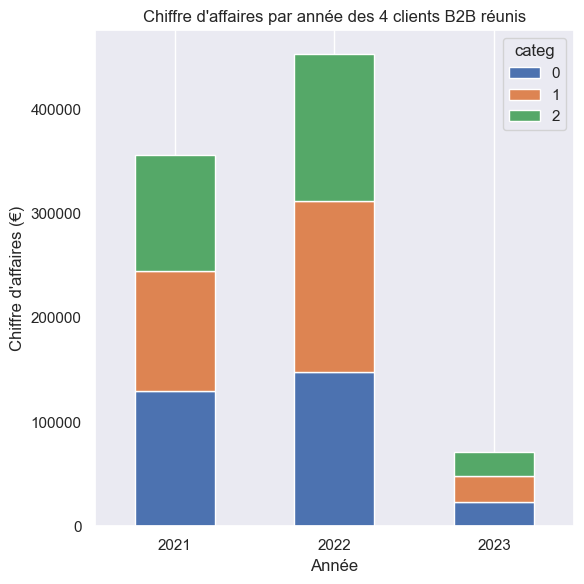

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

df_b2b_categ.plot(
    kind="bar",
    stacked=True,
    ax=ax
)

# Ajout d’un titre et axes formatés
ax.set_title("Chiffre d'affaires par année des 4 clients B2B réunis")
ax.set_xlabel("Année")
ax.set_ylabel("Chiffre d'affaires (€)")
ax.ticklabel_format(axis="y", style="plain")
plt.xticks(rotation=0)
plt.grid(axis="y")

plt.tight_layout()
plt.show()

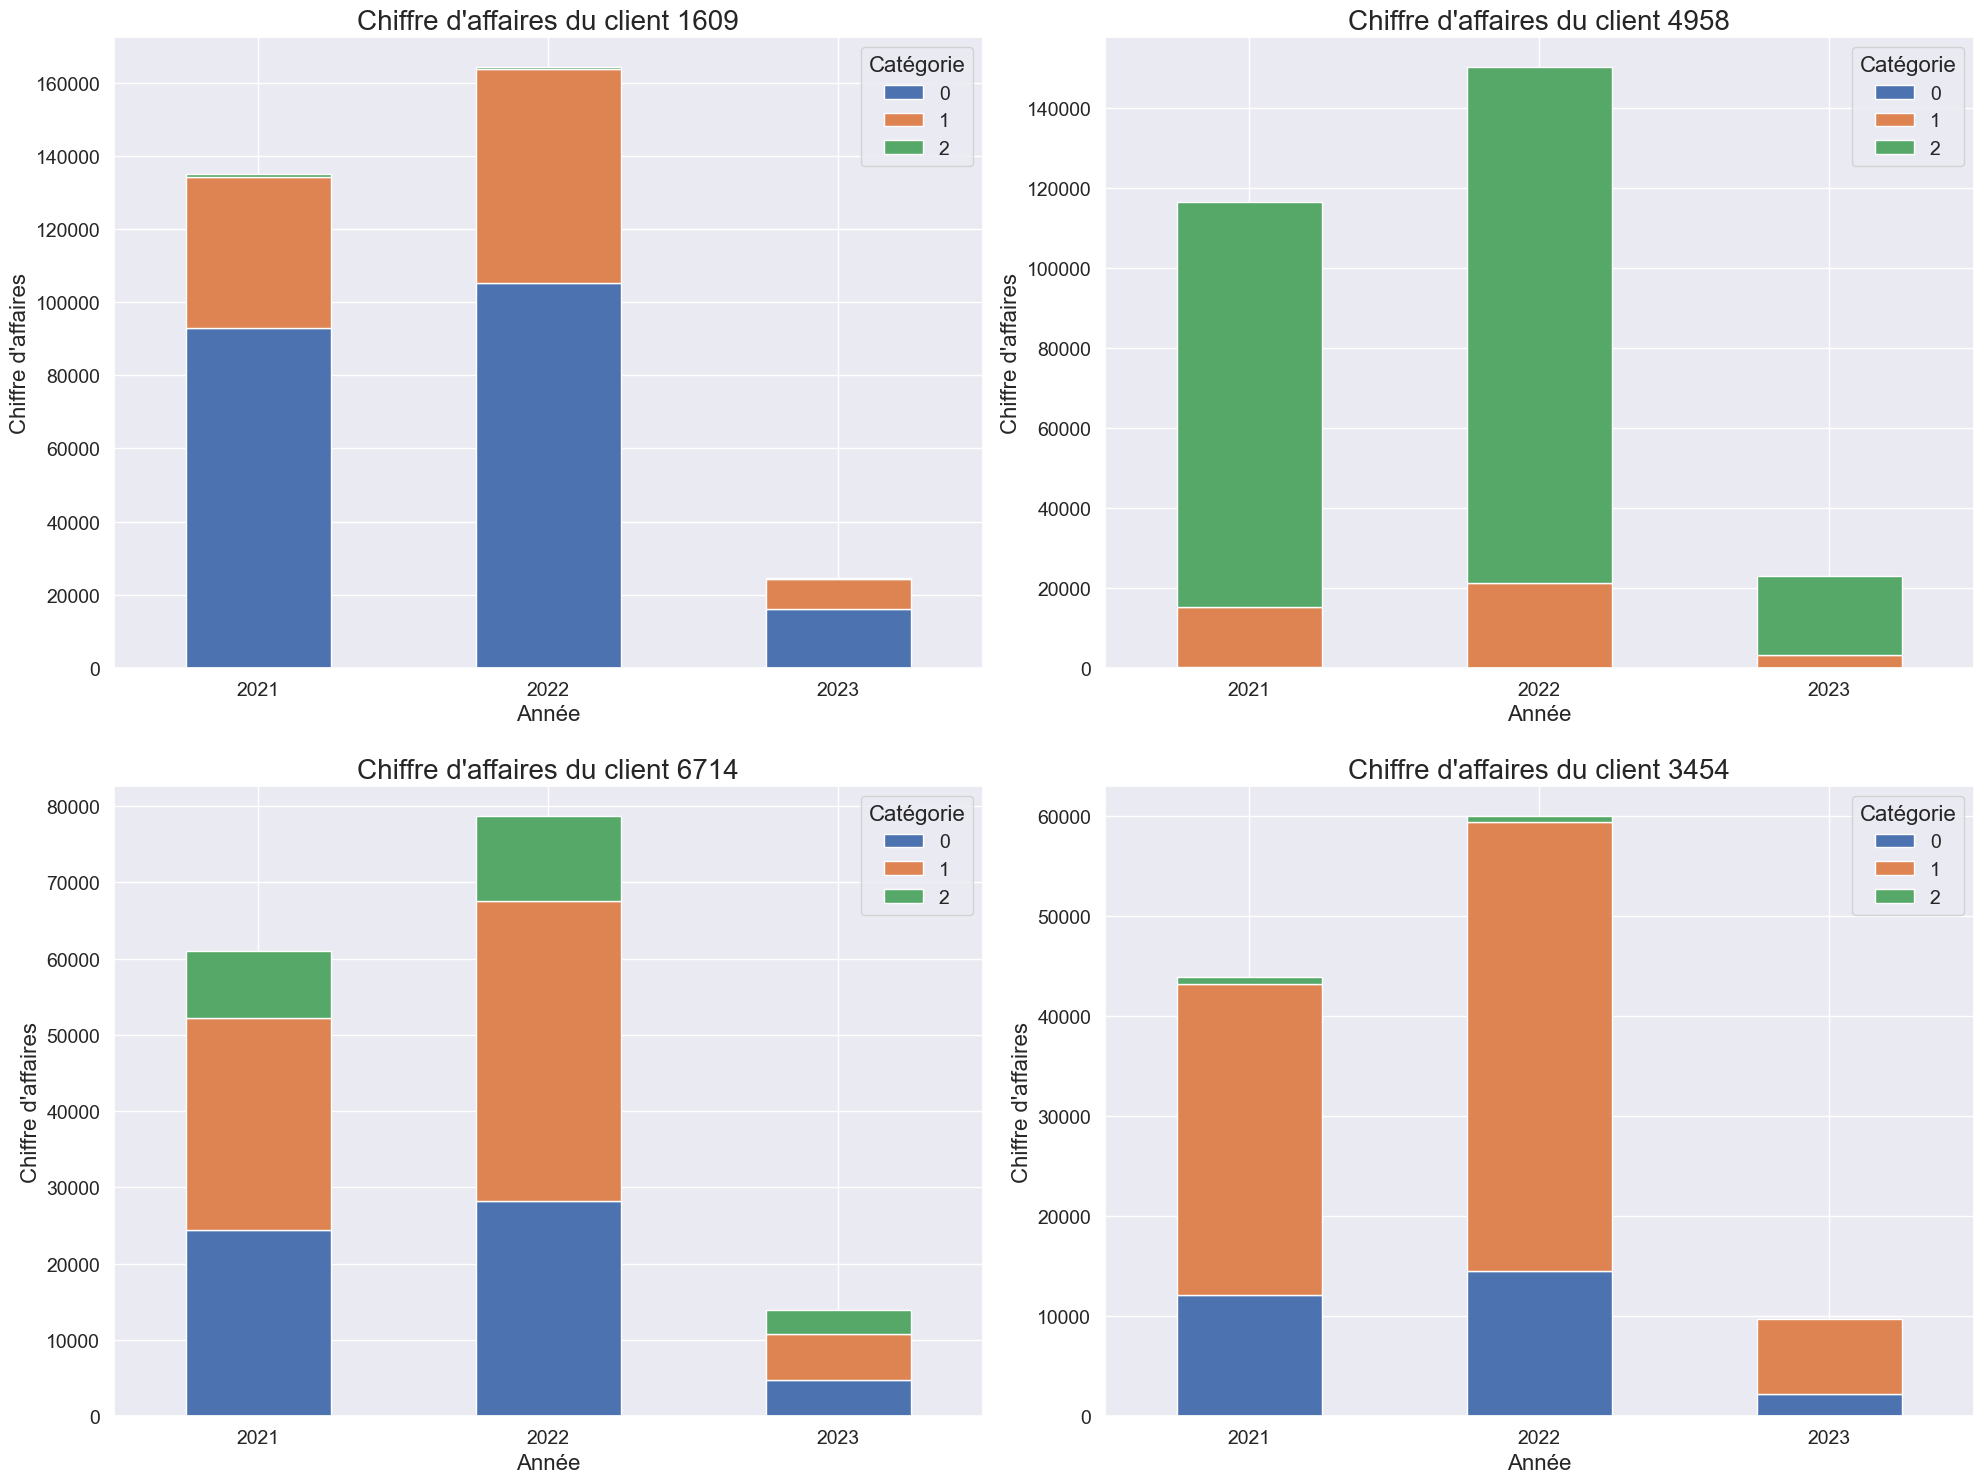

In [21]:
# Liste des DataFrames et titres associés
clients_categ = [
    (client_1609_categ, "Chiffre d'affaires du client 1609"),
    (client_4958_categ, "Chiffre d'affaires du client 4958"),
    (client_6714_categ, "Chiffre d'affaires du client 6714"),
    (client_3454_categ, "Chiffre d'affaires du client 3454")
]

# Initialisation de la grille
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Affichage dans une boucle
for (df_client, title), ax in zip(clients_categ, axes.flat):
    df_client.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Année", fontsize=16)
    ax.set_ylabel("Chiffre d'affaires", fontsize=16)
    ax.tick_params(axis='x', labelrotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(title="Catégorie", fontsize=14, title_fontsize=16)

plt.tight_layout(h_pad=2)
plt.show()

Cette fois, cela nous permet d'obtenir plusieurs informations intéressantes :

- Le client 1609 est plutôt axé sur la catégorie 0 et 1
- Le client 4958 est plutôt axé sur la catégorie 2
- Le client 6714 achète en très grande partie des produits de la catéogire 1, une légère partie de la catégorie 0 et une petite partie de la catégorie 2
- Le client 3454 achète essentiellement des produits de la catéogire 1 et une petite partie de la catégorie 0 également

Le client 4958 est le seul à acheter en très grande partie des produits de la catégorie 2. C'est essentiellement lui qui rapporte du CA pour cette catégorie. Son business est sans doute très différent des trois autres clients B2B.

## Courbe de Lorenz

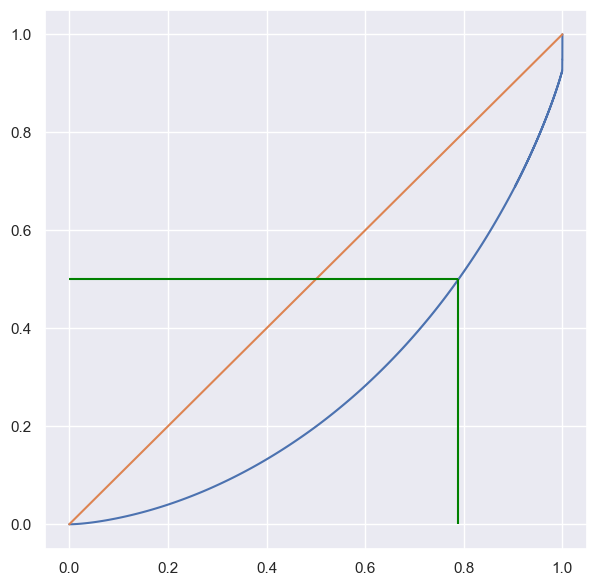

Indice de gini : 0.45


In [22]:
cum = customers.cumsum()
expenses = customers['price']
n = len(cum)

lorenz = np.cumsum(np.sort(expenses)) / expenses.sum()
lorenz = np.append([0], lorenz)

# Calcul de l'intersection
medial = lorenz[(lorenz < 0.5)].size / lorenz.size

# Création du graphique et ajout des points pour établir les intersections
plt.figure(figsize=(7,7))
plt.plot(np.linspace(0,1, len(lorenz)), lorenz, drawstyle="steps-post")
plt.plot(np.linspace(0,1, len(lorenz)), np.linspace(0,1,len(lorenz)))

# Incrustation de la médiane pour qu'elle s'arrête à l'intersection calculée à l'horizontal, soit 0.5
plt.hlines(xmin=medial, xmax=0, y=.5, color='green')

# Incrustation de la mediane pour qu'elle s'arrête à l'intersection calculée à la verticale, soit 0.5
plt.vlines(medial, ymin=0, ymax=0.5, color='green')
plt.show()

# Calcul de l'indice de gini
AUC = (lorenz.sum() - lorenz[-1] / 2 - lorenz[0] / 2) / n
S = 0.5 - AUC
gini = 2*S
print(f"Indice de gini : {gini:.2f}")

L'indice de gini est de 0.45. Il n'y a donc pas d'inégalité entre les clients et leurs achats pour la totalité du chiffre d'affaires.

# Genre

## Nombre d'achats et CA B2C

In [23]:
count_transactions = df_b2c["id_prod"].count()
count_transactions

632689

In [24]:
transactions_gender = df_b2c.groupby("sex")["price"].agg([
    "count", "sum"
])

transactions_gender

,count,sum
sex,,
f,329215,5707265.25
m,303474,5267688.57


In [25]:
women_transactions = transactions_gender["count"].iloc[0]
men_transactions = transactions_gender["count"].iloc[1]

women_revenue = transactions_gender["sum"].iloc[0]
men_revenue = transactions_gender["sum"].iloc[1]

print("Les clientes ont effectuées {:,.0f} achats.".format(women_transactions).replace(',', ' '))
print("Les clients ont effectuées {:,.0f} achats.".format(men_transactions).replace(',', ' '))
print("Le chiffre d'affaires pour les clientes est de {:,.0f} €,".format(women_revenue).replace(',',' '))
print("Le chiffre d'affaires pour les clients est de {:,.0f} €,".format(men_revenue).replace(',',' '))

Les clientes ont effectuées 329 215 achats.
Les clients ont effectuées 303 474 achats.
Le chiffre d'affaires pour les clientes est de 5 707 265 € 
Le chiffre d'affaires pour les clients est de 5 267 689 € 


In [26]:
# Proportion du CA généré
women_proportion_revenue = women_revenue / count_transactions * 100
men_proportion_revenue = men_revenue / count_transactions * 100

# proportion du nombre d'achats effectué
women_proportion_expenses = women_transactions / count_transactions * 100
men_proportion_expenses = men_transactions / count_transactions * 100

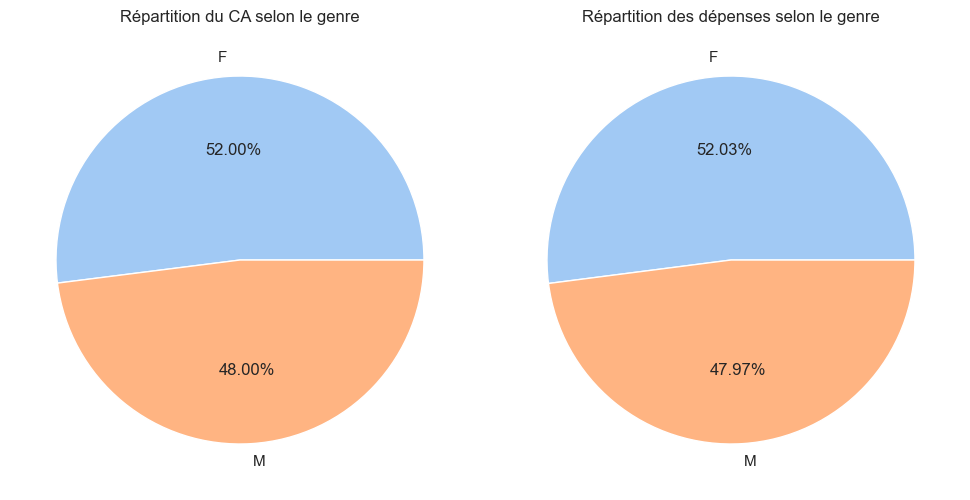

In [27]:
proportion_revenue_gender = [women_proportion_revenue, men_proportion_revenue]
proportion_revenue_expenses = [women_proportion_expenses, men_proportion_expenses]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(proportion_revenue_gender,
       labels=["F", "M"],
       autopct="%.2f%%",
       colors=sns.color_palette("pastel"))
ax1.set_title("Répartition du CA selon le genre")

ax2.pie(proportion_revenue_expenses,
       labels=["F", "M"],
       autopct="%.2f%%",
       colors=sns.color_palette("pastel"))
ax2.set_title("Répartition des dépenses selon le genre")

plt.tight_layout()
plt.show()

Si on prend en compte le CA et les dépenses généré par les particuliers, on remarque que les femmes dépensent et génèrent un peu plus que les hommes dans l'ensemble des catégories.

Pour rappel, le CA des clients B2C représente au total 92 %

## Achats par catégorie

In [28]:
transaction_counts_by_gender_category = pd.pivot_table(df_b2c,
                                                     index="sex",
                                                     columns="categ",
                                                     values="price",
                                                     aggfunc="count")

transaction_counts_by_gender_category

categ,0,1,2
sex,,,
f,200904,111331,16980
m,186589,101017,15868


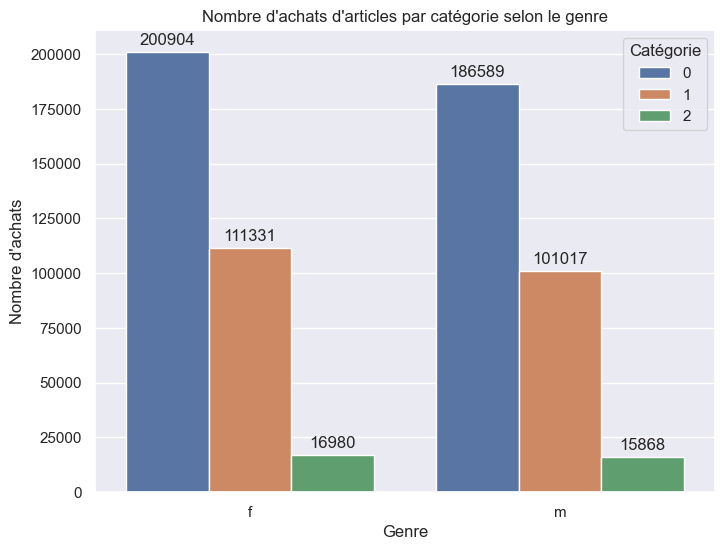

In [29]:
# Transformation minimale pour Seaborn
transaction_counts_by_gender_category_pivot = transaction_counts_by_gender_category.reset_index().melt(
    id_vars="sex", var_name="category", value_name="count")

# Graphique en barres groupées avec Seaborn
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="sex", y="count", hue="category", data=transaction_counts_by_gender_category_pivot)

# Ajouter les valeurs au-dessus des barres avec bar_label
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3)

# Annotations
plt.title("Nombre d'achats d'articles par catégorie selon le genre")
plt.xlabel("Genre")
plt.ylabel("Nombre d'achats")

plt.ticklabel_format(style='plain', axis='y')
plt.legend(title="Catégorie")
plt.show()

# Age

## Nombre de clients par tranche d'âges

In [30]:
df_age = df_b2c.groupby('range_age').agg({
    "client_id" : "count",
    "price" : "sum"
}).reset_index()

In [31]:
df_clients_age = df_age[["range_age", "client_id"]]

df_clients_age = df_clients_age.rename(columns={"client_id" : "number_clients"})

df_clients_age = df_clients_age.sort_values(by="range_age")
df_clients_age.head(10)

,range_age,number_clients
0,21-26,37820
1,27-31,26473
2,32-37,86443
3,38-42,99554
4,43-47,110497
5,48-53,107586
6,54-58,43954
7,59-63,36333
8,64-69,35325
9,70-74,20590


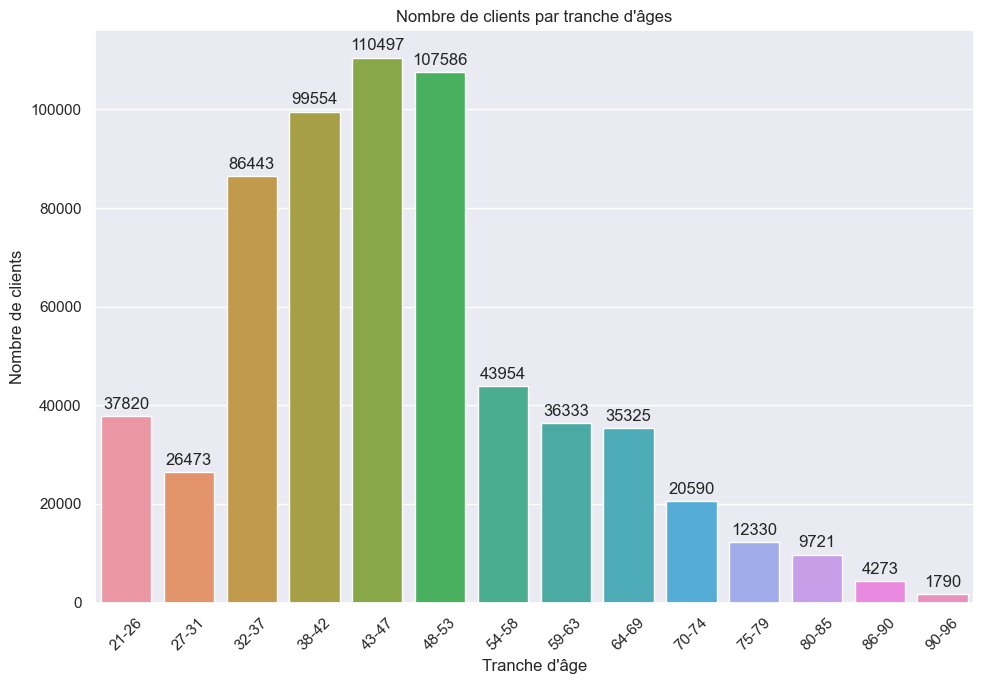

In [32]:
plt.figure(figsize=(10, 7))
ax = sns.barplot(x="range_age", y="number_clients", data=df_clients_age)

for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3)

plt.title("Nombre de clients par tranche d'âges")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## CA

In [33]:
df_revenue_range_age = df_age[["range_age", "price"]]

df_revenue_range_age = df_revenue_range_age.groupby("range_age").agg({
    "price" : "sum"
})

df_revenue_range_age = df_revenue_range_age.sort_values("price", ascending=False).reset_index()
df_revenue_range_age

,range_age,price
0,21-26,1514682.90
1,43-47,1470983.32
2,48-53,1420959.54
3,32-37,1419806.38
4,38-42,1313038.62
5,27-31,1080273.82
6,54-58,736720.44
7,59-63,610242.11
8,64-69,595528.79
9,70-74,343494.20


Un top 5 se dinstingue au vu des résultats :
- 21-26 ans
- 43-47 ans
- 48-53 ans
- 32-37 ans
- 38-42 ans

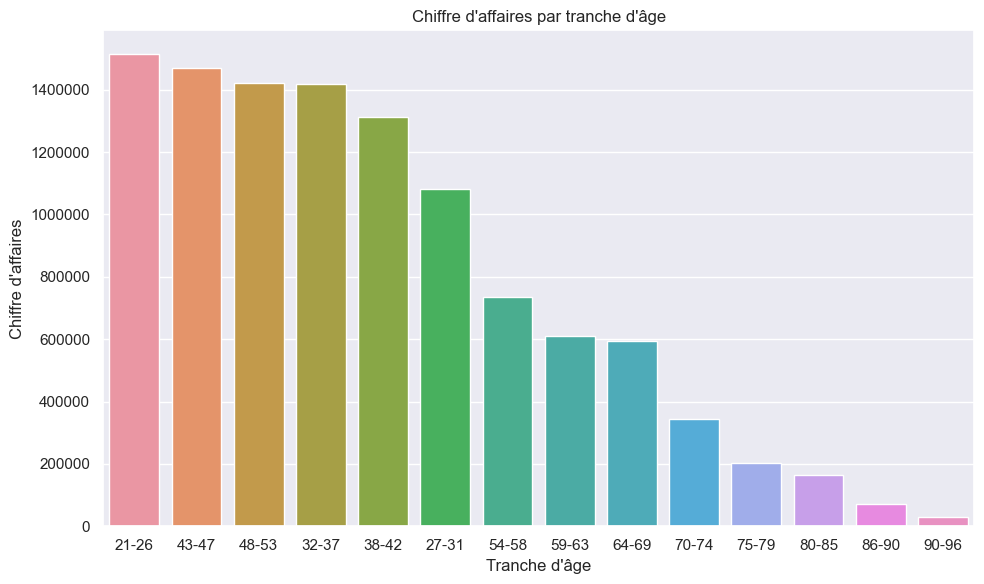

In [34]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="range_age", y="price", data=df_revenue_range_age)

plt.title("Chiffre d'affaires par tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Chiffre d'affaires")
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

## Catégorie d'achats

### Nombre d'achats

In [35]:
categ_count_range_age = pd.pivot_table(df_b2c,
                                index="range_age",
                                columns="categ",
                                values="id_prod",
                                aggfunc={"id_prod" : "count"})

categ_count_range_age.head(10)

categ,0,1,2
range_age,,,
21-26,8601,14222,14997
27-31,5813,9897,10763
32-37,60527,21475,4441
38-42,75737,23497,320
43-47,83787,26260,450
48-53,81656,25547,383
54-58,19131,24421,402
59-63,15614,20410,309
64-69,15491,19485,349


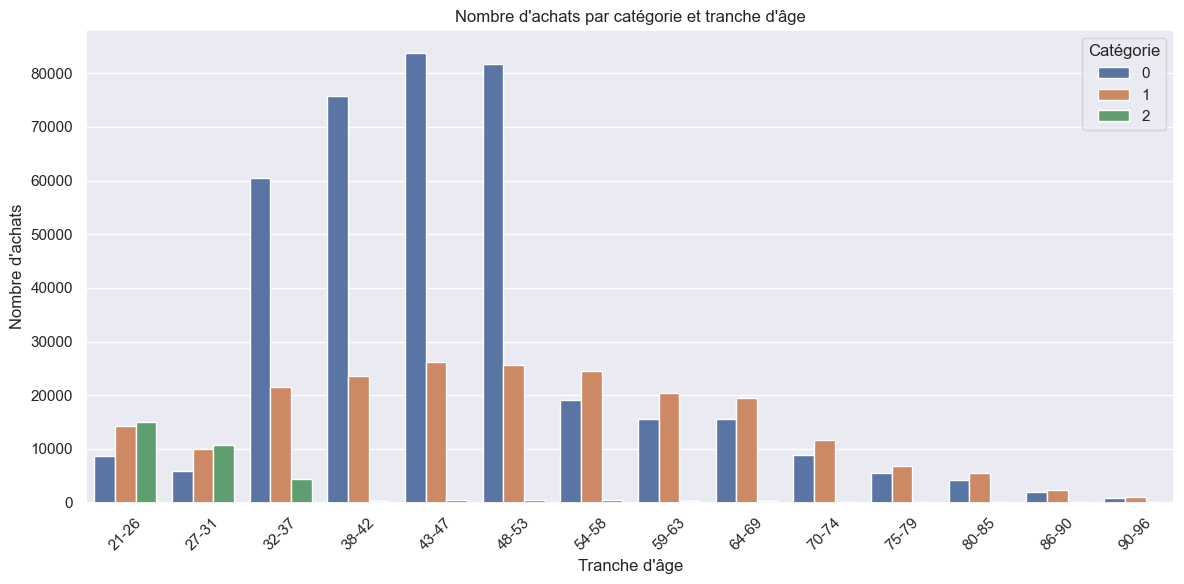

In [36]:
categ_count_range_age_long = categ_count_range_age.reset_index().melt(
    id_vars="range_age",
    var_name="category",
    value_name="count")

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="range_age", y="count", hue="category", data=categ_count_range_age_long)

plt.title("Nombre d'achats par catégorie et tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Nombre d'achats")
plt.xticks(rotation=45)
plt.legend(title="Catégorie")

plt.tight_layout()
plt.show()

Selon les catégories, différentes conclusions peuvent en sortir concernant le nombre d'achats :

- Catégorie 0 :
    - La grande majorité est essentiellement acheté par les 31-53 ans
    - En dehors de cette majorité, le reste de la clientèle est moins intéressé par cette catégorie 
- Catégorie 1 :
    - Le nombre d'achats est relativement stable, sauf à partir des 74 ans et plus
- Catégorie 2 :
    - Les 21-31 ans achètent à eux seuls plus que la totalité du reste des tranches d'âges réunies  

### CA

In [37]:
categ_revenue_range_age = pd.pivot_table(df_b2c,
                                        index="range_age",
                                        columns="categ",
                                        values="price",
                                        aggfunc="sum")

categ_revenue_range_age.head(10)

categ,0,1,2
range_age,,,
21-26,91978.89,291830.49,1130873.52
27-31,61490.85,203097.90,815685.07
32-37,645840.40,441849.96,332116.02
38-42,805598.48,477575.83,29864.31
43-47,891179.21,537912.63,41891.48
48-53,864273.39,522719.50,33966.65
54-58,204761.65,500897.48,31061.31
59-63,164911.39,419046.81,26283.91
64-69,166169.88,399652.58,29706.33


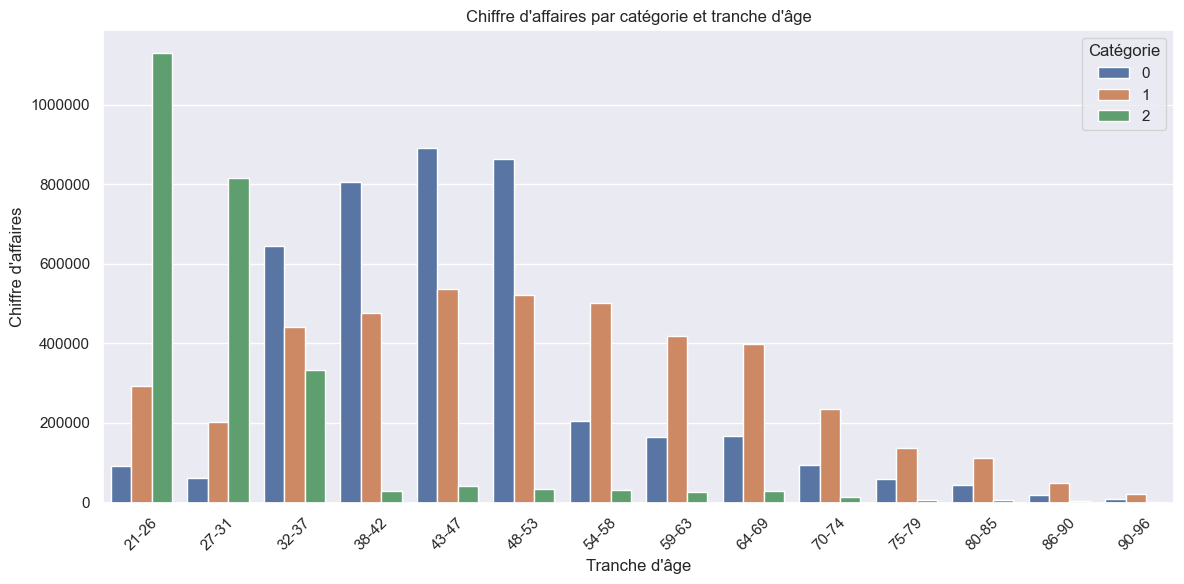

In [38]:
categ_revenue_range_age_long = categ_revenue_range_age.reset_index().melt(
    id_vars="range_age",
    var_name="category",
    value_name="revenue"
)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="range_age", y="revenue", hue="category", data=categ_revenue_range_age_long)

plt.title("Chiffre d'affaires par catégorie et tranche d'âge")
plt.xlabel("Tranche d'âge")
plt.ylabel("Chiffre d'affaires")
plt.xticks(rotation=45)
plt.legend(title="Catégorie")
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

Cette fois, c'est par rapport au CA que différentes conclusions peuvent en sortir :

- Catégorie 0 :
    - La très grande partie du CA est réparti sur les 31-53 ans
    - En dehors de cette tranche, la catégorie rapporte peu
- Catégorie 1 :
    - Le CA est assez étalé sur toutes les tranches d'âges, sauf à partir des 74 ans
- Catégorie 2 :
    - Les 21-37 ans représentent à eux seuls quasiment la totalité du CA

## Focus sur le top 5

Un peu plus haut, on avait distingué un top 5 qui se dessinait au vu des résultats, regardons ça d'un peu plus près. Petit rappel des tranches d'âges en question :

- 21-26 ans
- 32-37 ans
- 38-42 ans
- 43-47 ans
- 48-53 ans

In [39]:
categ_revenue_age = df_b2c.groupby(["age", "categ"])[["price"]].sum().reset_index()
categ_revenue_age

,age,categ,price
0,21,0,35914.36
1,21,1,118362.47
2,21,2,454736.86
3,22,0,9560.43
4,22,1,34435.66
...,...,...,...
223,95,1,3074.34
224,95,2,111.98
225,96,0,716.76
226,96,1,2359.10


In [40]:
ranges = {
    "21-26" : (21, 26),
    "32-37" : (32, 37),
    "38-42" : (38, 42),
    "43-47" : (43, 47),
    "48-53" : (48, 53),
}

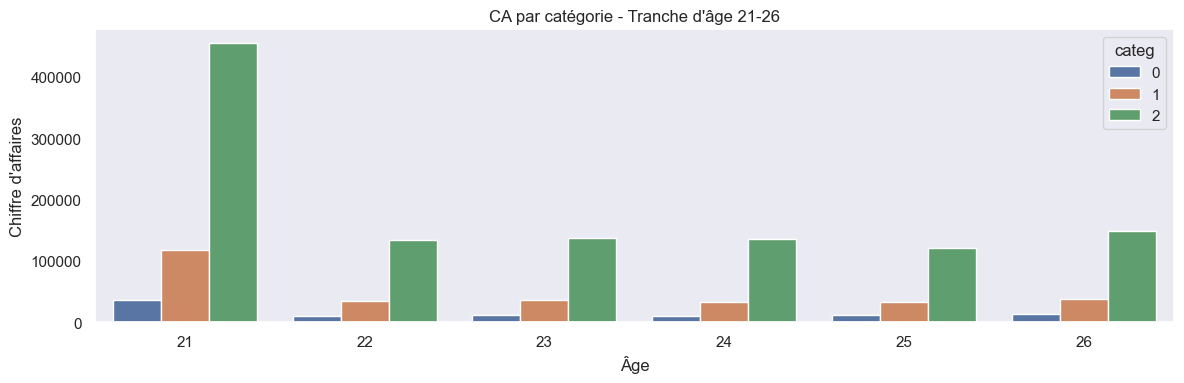

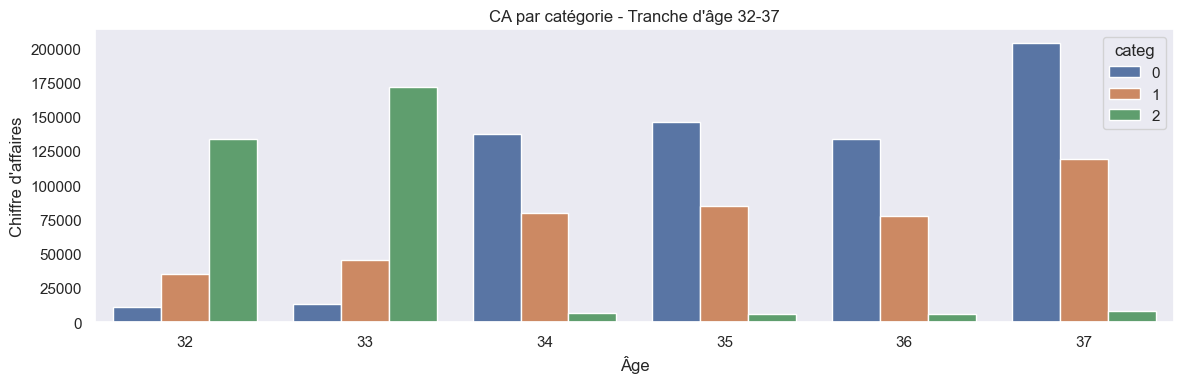

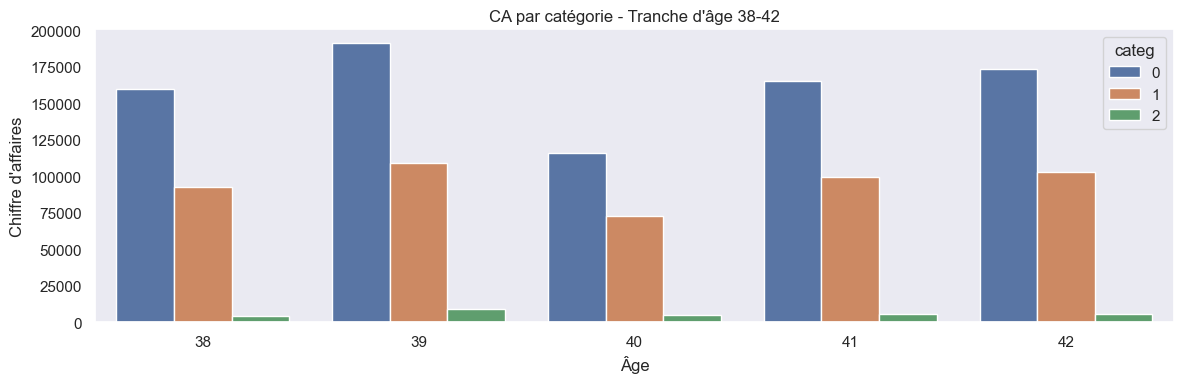

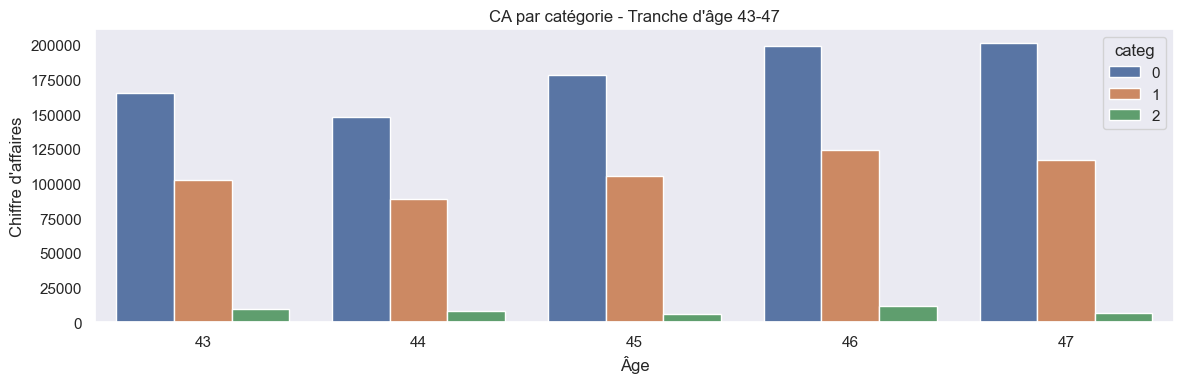

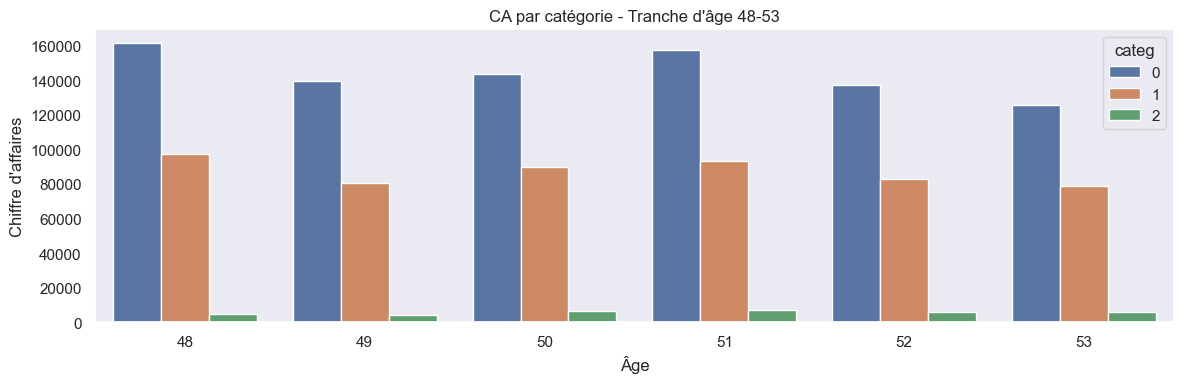

In [41]:
for label, (min_age, max_age) in ranges.items():
    df_range = df_b2c[(df_b2c["age"] >= min_age) & (df_b2c["age"] <= max_age)]
    grouped = df_range.groupby(["age", "categ"])["price"].sum().reset_index()

    plt.figure(figsize=(12, 4))
    sns.barplot(data=grouped, x="age", y="price", hue="categ")
    plt.title(f"CA par catégorie - Tranche d'âge {label}")
    plt.xlabel("Âge")
    plt.ylabel("Chiffre d'affaires")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

# Produits

In [42]:
df_categ = pd.pivot_table(
    df,
    index="year",
    columns="categ",
    values="price",
    aggfunc={"price" : "sum"}
)

df_categ

categ,0,1,2
year,,,
2021,1883946.13,1777995.85,1109810.26
2022,2194247.26,2485275.19,1430436.16
2023,343889.02,390451.65,240028.60


In [43]:
categ_describe = df.groupby("categ").agg({
    "price" : ["min", "max", "mean"]
})

categ_describe

price             
        min    max  mean
categ                   
0      0.62  40.99 10.64
1      2.00  80.99 20.49
2     30.99 300.00 76.21

On peut déjà noter quelques premières informations : 

- La catégorie 0 correspond à des produits "bas de gamme", comparé aux autres catégories.
- La catégorie 1 correspond plutôt à une "moyenne gamme"
- La catégorie 2 est plutôt dans le "haut de gamme"

En rapide conclusion, nos trois catégories correspondent à trois types de gammes de produits.

## Nombre d'articles

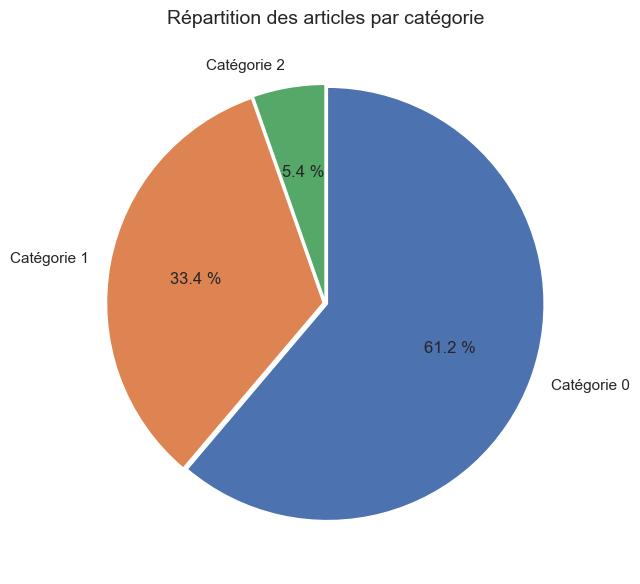

In [44]:
articles = df["id_prod"].groupby(df["categ"]).count()
labels = [f"Catégorie {c}" for c in articles.index]

plt.figure(figsize=(8, 6))
plt.pie(
    articles,
    labels=labels,
    autopct=lambda p: f"{p:.1f} %",
    explode=[0.01] * len(labels),
    startangle=90,
    counterclock=False
)

plt.title("Répartition des articles par catégorie", fontsize=14)
plt.tight_layout()
plt.show()

## Paniers moyens

### Général

In [45]:
average_cart = df.groupby(["session_id"])["price"].sum().mean()
round(average_cart, 2)

34.64

### Catégories

In [46]:
average_cart_categ = {}

for cat in sorted(df["categ"].unique()):
    mean_cart_categ = df[df["categ"] == cat].groupby("session_id")["price"].sum().mean()
    average_cart_categ[f"Catégorie {cat}"] = mean_cart_categ
    print(f"Le panier moyen est à {mean_cart_categ:,.2f} € pour la catégorie {cat}")

Le panier moyen est à 19.61 € pour la catégorie 0
Le panier moyen est à 25.97 € pour la catégorie 1
Le panier moyen est à 90.94 € pour la catégorie 2


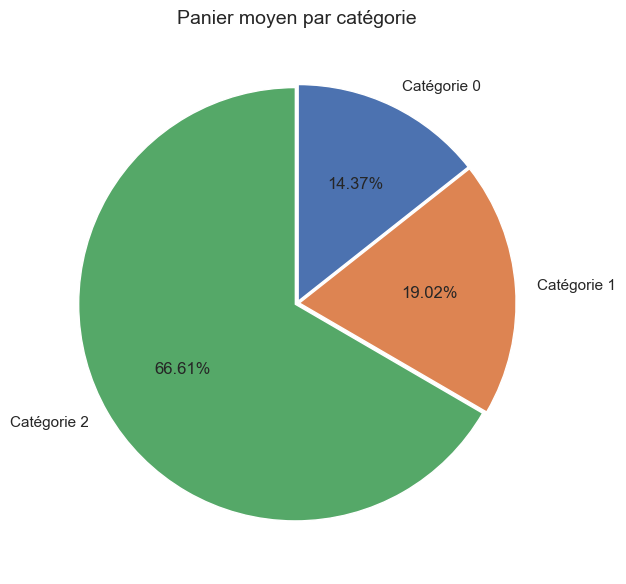

In [47]:
plt.figure(figsize=(8, 6))
plt.pie(
    average_cart_categ.values(),
    labels=average_cart_categ.keys(),
    autopct="%.2f%%",
    explode=[0.01] * len(average_cart_categ),
    startangle=90,
    counterclock=False
)

plt.title("Panier moyen par catégorie", fontsize=14)
plt.tight_layout()
plt.show()

# Fréquences et répartition d'achats

## Fréquences par tranches d'âges

In [48]:
def frequency(x):
    d = {}
    d["frequency"] = (x["session_id"].count() / x["client_id"].value_counts().count())
    return pd.Series(d, index=["frequency"])

In [49]:
df_range_age_frequency = df_b2c.groupby(["year", "month", "range_age"]).apply(frequency).reset_index()
df_range_age_frequency

,year,month,range_age,frequency
0,2021,3,21-26,2.66
1,2021,3,27-31,2.57
2,2021,3,32-37,5.91
3,2021,3,38-42,6.87
4,2021,3,43-47,6.38
...,...,...,...,...
331,2023,2,70-74,2.94
332,2023,2,75-79,3.12
333,2023,2,80-85,3.09
334,2023,2,86-90,2.63


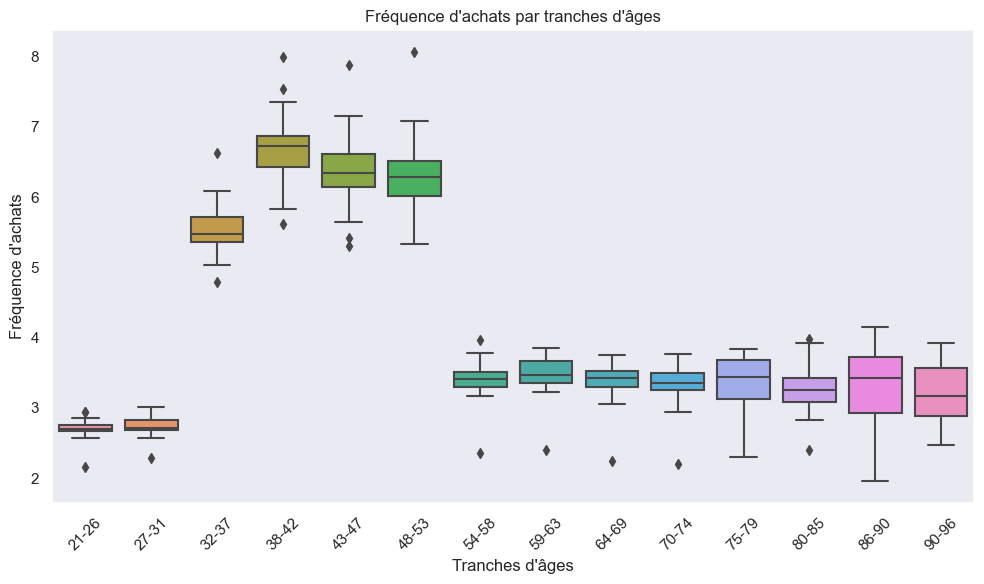

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="range_age",
           y="frequency",
           data=df_range_age_frequency,
           showfliers=True)

plt.grid(axis="y")
plt.title("Fréquence d'achats par tranches d'âges")
plt.xticks(rotation=45)
plt.xlabel("Tranches d'âges")
plt.ylabel("Fréquence d'achats")
plt.tight_layout()
plt.show()

## Réparition des achats par âges

In [51]:
age_purchase_distribution = df_b2c.groupby("age").count().reset_index()
age_purchase_distribution = age_purchase_distribution[["age", "session_id"]]
age_purchase_distribution["age_freq_distribution"] = age_purchase_distribution["session_id"] / sum(age_purchase_distribution["session_id"])
age_purchase_distribution

,age,session_id,age_freq_distribution
0,21,15149,0.02
1,22,4371,0.01
2,23,4587,0.01
3,24,4252,0.01
4,25,4415,0.01
...,...,...,...
71,92,327,0.00
72,93,311,0.00
73,94,170,0.00
74,95,226,0.00


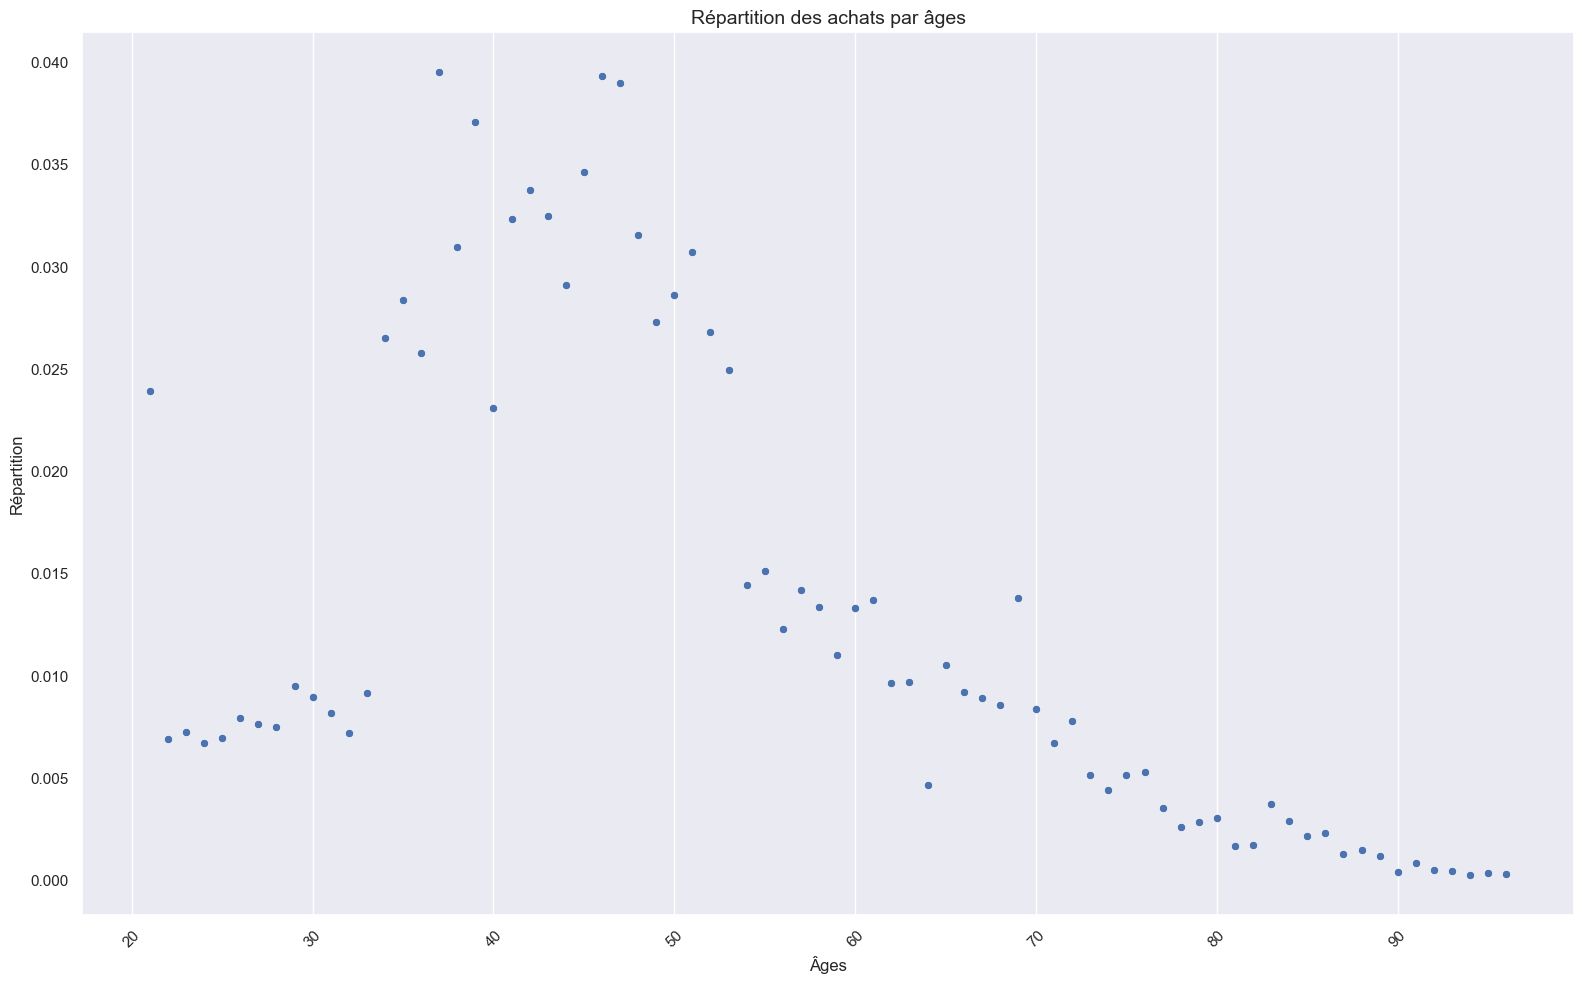

In [52]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='age', 
            y='age_freq_distribution', 
            data=age_purchase_distribution)
plt.grid(axis='y')
plt.title("Répartition des achats par âges", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Âges")
plt.ylabel("Répartition")
plt.tight_layout()
plt.show()

In [53]:
df_b2c.describe()

,price,categ,age,year,month,day
count,632689.00,632689.00,632689.00,632689.00,632689.00,632689.00
mean,17.35,0.44,47.21,2021.67,6.50,15.77
std,18.09,0.59,13.85,0.62,3.48,8.81
min,0.62,0.00,21.00,2021.00,1.00,1.00
25%,8.82,0.00,38.00,2021.00,3.00,8.00
50%,13.99,0.00,46.00,2022.00,6.00,16.00
75%,18.99,1.00,54.00,2022.00,9.00,23.00
max,300.00,2.00,96.00,2023.00,12.00,31.00


In [54]:
df_b2b.describe()

,price,categ,age,year,month,day
count,46643.00,46643.00,46643.00,46643.00,46643.00,46643.00
mean,18.89,0.47,46.84,2021.67,6.54,15.69
std,21.18,0.64,9.10,0.62,3.48,8.70
min,0.62,0.00,26.00,2021.00,1.00,1.00
25%,8.99,0.00,45.00,2021.00,4.00,8.00
50%,13.99,0.00,45.00,2022.00,6.00,16.00
75%,19.53,1.00,56.00,2022.00,10.00,23.00
max,300.00,2.00,57.00,2023.00,12.00,31.00


In [56]:
df_b2b["client_id"].value_counts()

client_id
c_1609    25488
c_6714     9187
c_3454     6773
c_4958     5195
Name: count, dtype: int64

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679332 entries, 0 to 679331
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679332 non-null  object 
 1   date        679332 non-null  object 
 2   session_id  679332 non-null  object 
 3   client_id   679332 non-null  object 
 4   price       679332 non-null  float64
 5   categ       679332 non-null  int64  
 6   sex         679332 non-null  object 
 7   age         679332 non-null  int64  
 8   year        679332 non-null  int64  
 9   month       679332 non-null  int64  
 10  day         679332 non-null  int64  
 11  range_age   679332 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 62.2+ MB


In [58]:
df.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,year,month,day,range_age
0,0_1518,2022-05-20 13:21:29,s_211425,c_103,4.18,0,f,39,2022,5,20,38-42
1,0_1627,2022-06-18 05:55:31,s_225494,c_103,3.99,0,f,39,2022,6,18,38-42
2,0_1104,2023-02-08 17:31:06,s_338755,c_103,13.21,0,f,39,2023,2,8,38-42
3,0_1390,2021-04-20 06:18:39,s_23078,c_103,19.37,0,f,39,2021,4,20,38-42
4,0_1547,2022-03-15 19:54:53,s_179629,c_103,8.99,0,f,39,2022,3,15,38-42


In [59]:
df_b2c.head()

,id_prod,date,session_id,client_id,price,categ,sex,age,year,month,day,range_age
0,0_1518,2022-05-20 13:21:29,s_211425,c_103,4.18,0,f,39,2022,5,20,38-42
1,0_1627,2022-06-18 05:55:31,s_225494,c_103,3.99,0,f,39,2022,6,18,38-42
2,0_1104,2023-02-08 17:31:06,s_338755,c_103,13.21,0,f,39,2023,2,8,38-42
3,0_1390,2021-04-20 06:18:39,s_23078,c_103,19.37,0,f,39,2021,4,20,38-42
4,0_1547,2022-03-15 19:54:53,s_179629,c_103,8.99,0,f,39,2022,3,15,38-42


In [62]:
df_b2c.to_csv("../data/df_b2c.csv", index=False, sep=";", encoding="utf-8-sig")

In [63]:
df_b2b.to_csv("../data/df_b2b.csv", index=False, sep=";", encoding="utf-8-sig")

In [64]:
df.to_csv("../data/df_final.csv", index=False, sep=";", encoding="utf-8-sig")